# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.545298,True,5.725551
1,-0.680002,False,-2.957086
2,-1.424410,False,-3.646981
3,-0.727553,False,-1.783657
4,0.345687,False,1.604299
...,...,...,...
995,-1.665431,False,-2.740651
996,-0.328970,True,4.107379
997,-0.869654,False,-2.396288
998,-1.455626,False,-2.466975


<Axes: xlabel='v0'>

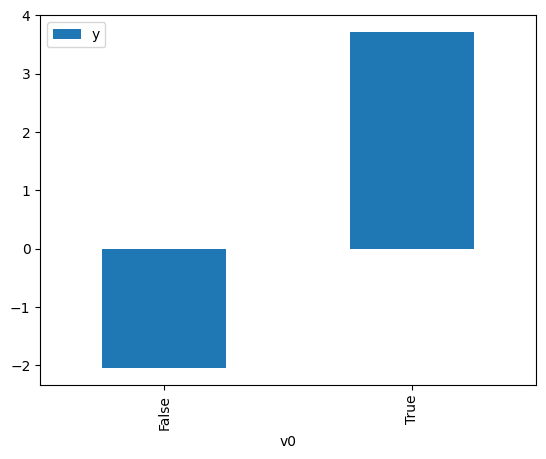

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

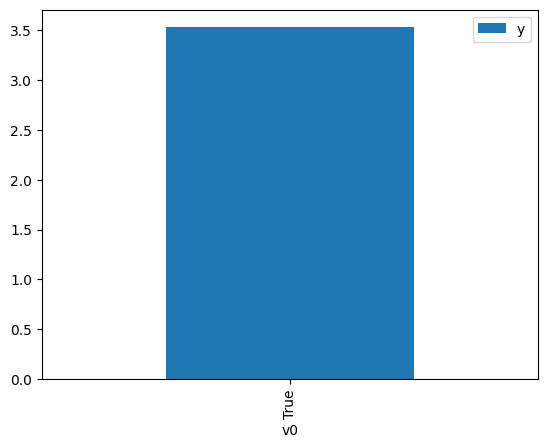

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.312724,False,-1.159518,0.658247,1.519187
1,-1.252253,False,-4.264581,0.908265,1.101000
2,-0.165841,False,-1.707496,0.598579,1.670625
3,-0.719005,False,-2.008620,0.796318,1.255779
4,-0.761098,False,-2.371420,0.807957,1.237690
...,...,...,...,...,...
995,-0.299416,False,-0.136585,0.653011,1.531368
996,-0.034330,False,-2.845620,0.542494,1.843340
997,-1.873365,False,-7.374339,0.966912,1.034221
998,-0.972313,False,-2.510268,0.858736,1.164502


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.259640,True,3.396649,0.362855,2.755918
1,-0.475553,True,2.944791,0.281057,3.557993
2,0.867176,True,7.698955,0.802263,1.246474
3,0.405833,True,5.087518,0.644879,1.550678
4,-0.932299,True,1.777816,0.149935,6.669545
...,...,...,...,...,...
995,-0.694590,True,4.165100,0.210669,4.746785
996,-1.785493,True,-0.535101,0.038353,26.073466
997,-0.817684,True,1.740214,0.177206,5.643139
998,-1.207657,True,2.161040,0.098418,10.160716


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              8271.
Date:                Wed, 06 Dec 2023   Prob (F-statistic):                        0.00
Time:                        21:41:04   Log-Likelihood:                         -1429.5
No. Observations:                1000   AIC:                                      2863.
Df Residuals:                     998   BIC:                                      2873.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5110      0.027     94.082      0.000       2.459       2.563
x2             4.9076      0.059     82.636      0.000       4.791       5.024
==============================================================================
Omnibus:                        3.759   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                3.667
Skew:                          -0.147   Prob(JB):                        0.160
Kurtosis:                       3.045   Cond. No.                         2.23
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""